# Statistische Prozesskontrolle (SPC)

In der Industrie werden Fertigungsprozesse anhand statistischer Prozesskontrolle überwacht. Typische Statistiksoftware zur Prozessüberwachung gibt häufig vorgefertigte Zusammenfassungen für den schnellen Überblick. In Minitab (einer in der Halbleiterindustrie weit verbreiteten Software) zeigt z.B. folgende Informationen:

![Process Capability Sixpack mit Minitab](minitab-capability-sixpack.png)

(die Abbildung liegt auch auf moodle)


Als Ingenieur/in in Entwicklung oder Qualitätsmanagement werden Sie mit solchen Informationen arbeiten. Für die nächsten Labore sind Sie daher die zuständigen Entwickler für einen neuen Fertigungsprozess. Dieser soll natürlich im Sinne der Industrie 4.0 automatisiert überwacht werden. Dazu basteln Sie nun eine Prozesskontrolle und erstellen schrittweise ähnliche Graphen und lernen welche Fertigungsfehler Sie so gut abfangen und für welche Sie sich vielleicht ein paar Tricks einfallen lassen müssen.



### Literatur
- zum 1. Teil: Möhrke, Runge, Arbeiten mit Messdaten: https://link.springer.com/book/10.1007%2F978-3-662-60660-5
- zum 2. Teil: Papula Band 3, Kapitel 4.6 (Ansonsten gibt es hier zwar sehr viel Spezialliteratur, die ist aber leider didaktisch eher unbrauchbar. Zudem hat hier jede Branche und jede Firma leicht andere Vorgaben, so dass die Berechnungen verschiedener Quellen in ihren Details nicht konsistent sind. Hier sollen die Konzepte im Mittelpunkt stehen.)


### Lernziele:
Wir schauen uns in zwei Laboren die statistische Prozesskontrolle an, zunächst mit (hoffentlich) normalverteilten Daten. Im nächsten Schritt mit nicht normalverteilten Daten. Sie sollen am Ende dieser beiden Labore:
- Regelkarten erstellen und interpretieren können
- Messdaten anhand verschiedener Vorgehen auf Verteilung prüfen (Histogramm, Wahrscheinlichkeitsnetz, Test) und Ergebnis interpretieren können
- Prozessfähigkeit einschätzen und anhand von Prozessfähigkeitsindizes bewerten können
- Messstreuung und Prozessstreuung unterscheiden können
- Regelkarten nutzen können, um weitere Analysen vorzubereiten (ANOVA und ähnliche Themen)

In [2]:
#Nötige Module importieren

#Dateien einlesen
import pandas as pd
#Plotten
import matplotlib.pyplot as plt
import seaborn as sns
#Numerische Operationen
import numpy as np
#Statistisches Werkzeug
from scipy import stats
import statsmodels.api as sm
import statsmodels.stats.descriptivestats as ds

## 1. Der neue Fertigungsprozess: 20-seitige Würfel aus dem fakultätseigenen 3D-Drucker

Die Fakultät N hat einen eigenen 3D-Drucker, mit dem immer wieder Bauteile für verschiedene Abschlussarbeiten und Forschungsprojekte gerdruckt werden. Die Einstellungen für so einen Druckprozess müssen für jedes Bauteil neu optimiert werden. Für unser DAT-Projekt haben wir versucht günstige (d.h. keine Stützstruktur, relativ schnelle Prozesszeit) 20-seitige Würfel zu drucken und fragen uns nun, wie gut ist dieser Druckprozess?

In einem ersten Schritt erhält jeder einen Würfel aus dem fakultätseigenen 3D-Drucker. Wie breit ist dieser?

Führen Sie die Messung anhand der beschlossenen Messvorschrift durch. Tragen Sie Ihre Messergebnisse auch bei mir auf dem PC ein, die Daten aller Würfel werden für die nächste Aufgabe benötigt.

- Stellen Sie Ihre Daten grafisch dar und geben Sie das Messergebnis an (natürlich incl. Messunsicherheit). (z.B. 95%-Konfidenzintervalls für den Mittelwert bei Annahme normalverteilter Daten)
- Stellen Sie sich vor, Sie müssten die Daten ans Management reporten. Wie würden Sie in 1-2 Sätzen die Bedeutung des Konfidenzintervalls erläutern?

(array([17.66369521, 17.85596944, 17.91517181, 17.83636638]), array([18.52737622, 18.33510199, 18.27589962, 18.35470505]))


c:\Users\pawel\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:3643: FutureWarning: The behavior of DataFrame.std with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return std(axis=axis, dtype=dtype, out=out, ddof=ddof, **kwargs)
c:\Users\pawel\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: xlabel='1->20', ylabel='Count'>

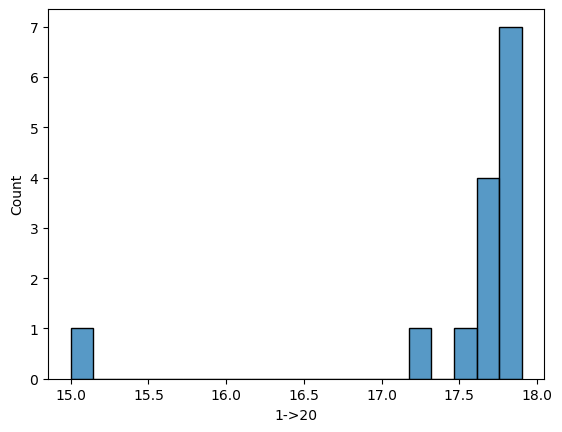

In [3]:
#TODO Daten darstellen, Messunsicherheit bestimmen, Konfidenzintervall per python Formel (z.B. scipy.stats.t.interval()) berechnen und kurz erläutern
data = pd.read_csv("./ikosaeder.csv",delimiter=";", decimal=",")

mean=np.mean(data)
std=np.std(data,ddof=1)
n=len(data)
alpha=0.05
t=stats.t.ppf(1-alpha/2,df=n-1)
ci=stats.t.interval(1-alpha,df=n-1,loc=mean,scale=std/np.sqrt(n))
print(ci)

sns.histplot(data["1->20"])


## 2. Erstellung von Regelkarten
Stellen Sie sich nun folgende Situation vor:
Sie produzieren Bauteile mit einer gewissen Größe. Nun wollen Sie Ihre Produktion überwachen und entnehmen der Fertigung in regelmäßigen Abständen Bauteile (z.B. aus jeder 5. Waferbox wird von 20 Wafern einer entnommen und je 5 Chips werden vermessen). 

Bedenken Sie: jede einzelne dieser Messungen hat eine Messunsicherheit! Damit die Schwankungen zwischen den Teilen richtig erkannt werden, muss Ihr Messsystem genau genug sein, um diese Unterschiede abbilden zu können. Hierfür führt man (eigentlich vorher) eine Messsystemanalyse durch - das ist eine unfassbar stupide Aufgabe, die wir uns aus Zeitgründen hier sparen. Lesen Sie bei Bedarf in entsprechender Literatur nach.

Hier gehen wir nun davon aus, dass unser Messsystem genau genug ist und wollen den Prozess anhand einer Regelkarte überwachen. Dafür hat jeder 1 Würfel aus dem fakultätseigenen 3D-Drucker in der ersten Aufgabe vermessen. Die gesammelten Daten lege ich, sobald alle Messergebnisse verfügbar sind, auf moodle ab.

### 2.1 Einlesen und Überprüfen der Daten auf Korrektheit und auf Verteilung

In [4]:
#TODO: Daten einlesen und überprüfen ob die Datentabelle korrekt dargestellt wird (Jede Beobachtung 1 Zeile, jede Variable 1 Spalte etc.)
data=pd.read_csv("ikosaeder.csv", delimiter=";", decimal=",") #Einlesen von csv Files als DataFrame
print(data)

    1->20  14->7  11->10  3->18
0   17.70  18.35   18.35  18.25
1   17.80  17.45   18.15  18.35
2   17.50  18.10   17.70  18.10
3   15.00  18.80   17.10  19.20
4   17.85  18.20   17.90  18.45
5   17.90  18.80   17.85  19.35
6   17.70  17.70   18.00  18.15
7   17.75  18.25   18.00  18.30
8   17.80  18.10   18.00  18.30
9   17.80  18.30   18.00  18.50
10  17.90  18.80   17.50  19.10
11  17.65  18.40   18.10  19.10
12  17.85  18.85   17.95  19.15
13  17.30  18.35   17.60  18.90


In [ ]:
#TODO: überprüfen Sie die kompletten Daten auf Normalverteilung
melted_data=data.melt()
stats.shapiro(melted_data["value"])
# Shaprio Test deutet auf keine Normalverteilung der Daten hin

ShapiroResult(statistic=0.8607710599899292, pvalue=1.1849977454403415e-05)

### 2.2 Erstellung der Regelkarten
Die Daten sind nun in einer Tabelle gespeichert. Wir wollen sie in einer Regelkarte so darstellen, dass die Messungen der einzelnen Würfel unterscheidbar sind. Orientieren Sie sich an dem Beispiel oben und erstellen Sie drei Karten:
- Einzelwertkarte (unterstes Bild): Alle Einzelmessungen werden dargestellt, allerdings gruppiert nach Bauteil
- Mittelwertkarte (X-quer-Karte): eine Karte mit den Mittelwerten, um Mittelwertsverschiebungen zu erkennen. Nachteil: Extremwerte gehen unter
- Standardabweichungskarte (S-Karte) (im Beispiel Range statt S-Karte): eine Karte, um die Streuung zu überwachen und so Extremwerte zu erkennen 



In [ ]:
# TODO: Erstellen Sie drei Regelkarten (Einzelwertkarte, Mittelwertkarte, Standardabweichungskarte)
# Einzelwertkarte: Stellen Sie die Daten so dar, dass jede Beobachtung (= 1 Würfel) an gleicher Stelle der x-Achse steht
# Mittelwertkarte: Stellen Sie die Mittelwerte zu jedem Würfel dar
# Hinweis: transponieren eines DataFrames: data.T. Dann können Sie Größen wie Mittelwerte mit data.T.mean() berechnen
means = data.T.mean()
# Standardabweichungskarte: Stellen Sie die Standardabweichungen zu jedem Würfel dar
stds = data.T.std(ddof=1) # std, var etc. immer mit ddof=1 berechnen, nur mit ddof=1 wird die erwartungstreue Schätzung verwendet. Verschiedene Python Bibliotheken verwenden unterschiedliche default Werte

### 2.3 Berechnung der Eingriffsgrenzen

Regelkarten werden mit Eingriffsgrenzen/Kontrollgrenzen versehen. D.h. wenn die Kenndaten einer neu hinzukommenden Stichprobe (Mittelwert + Standardabweichung) statistisch unwahrscheinlich ist, wird ein Alarm ausgegeben (diesen Alarm brauchen sie nicht einzubauen). Für die Berechnung der Eingriffgrenzen gehen wir davon aus, dass die Daten normalverteilt sind. (Ein Beispiel zu nicht normalverteilten Daten schauen wir uns im nächsten Labor an.)

#### Eingriffsgrenzen für die Mittelwertkarte

Für die Mittelwertkarte ist es üblich die Eingriffsgrenzen auf ein Konfidenzintervall für den Mittelwert mit dem Faktor $z=\pm 3$ zu setzen, also auf Center +/- 3*Standardfehler:

 $\mu-z\frac{\sigma}{\sqrt{n}}\leq \bar{x}\leq \mu+z\frac{\sigma}{\sqrt{n}}$
 
(Das ist nicht ganz das Konfidenzintervall für den Mittelwert, denn hier steht der Schätzwert in der Mitte und der bekannte Wert der Grundgesamtheit wird für die Berechnung der Grenzen genutzt (siehe Papula Band 3, Kapitel 4.6, Formel III-252 für die Eingriffsgrenzen zur Mittelwertskarte)).

Berechnen Sie anhand der Verteilungsfunktion der Normalverteilung:
- wie häufig kommt es durch Zufall zu Werten außerhalb dieses Bereichs? (d.h. wie groß ist die Überdeckungswahrscheinlichkeit dieser Intervallschätzung?)
- die Anzahl Fehlalarme in 1 Million Werte

In [ ]:
# TODO: Berechnen oder recherchieren Sie die Überdeckungswahrscheinlichkeit der Eingriffsgrenzen für die Mittelwertkarte

In [ ]:
# TODO: Berechnung der Eingriffsgrenzen für die Mittelwertkarte



#### Eingriffsgrenzen für die Standardabweichungskarte
Bei normalverteilten folgt die Varianz einer Chi-Quadrat Verteilung. Leider ist die Stichprobenverteilung der Varianz nicht normalverteilt. Daher ist die Berechnung der Eingriffsgrenzen mit dem Faktor 3 nicht korrekt.
Aus dem Konfidenzintervall für die Varianz (Sachs, Kapitel 6.10) lässt sich analog zur Umformung beim Mittelwert folgender Toleranzbereich für die Standardabweichung herleiten: 

$\sigma \sqrt{\frac{\chi^2_{n-1,\alpha/2}}{n-1}}\leq s \leq \sigma \sqrt{\frac{\chi^2_{n-1,1-\alpha/2}}{n-1}}$

Berechnen Sie mit diesen Infos die Eingriffgrenzen für die Standardabweichungskarte zum 99% Konfidenzniveau.


In [ ]:
# TODO: Berechnung der Eingriffsgrenzen für die Standardabweichungskarte
# Chi-Quadrat Verteilung: stats.chi2.ppf(1-alpha/2,df=n-1)

In [ ]:
# TODO: Mittelwert - und Standardabweichungskarte mit Eingriffsgrenzen darstellen
# (OEG: obere Eingriffsgrenze, UEG: untere Eingriffsgrenze bzw. UCL: upper control limit, LCL: lower control limit)
# Einfügen horizontaler Linien in einen Graph: axs[0].axhline(value,color='r',label='')

# ein Code - Vorschlag für die Mittelwertkarte:
fig, axs = plt.subplots(2, 1, figsize=(10, 5))
axs[0].set_title("X-Bar-Chart")
axs[0].axhline(UCL_mean,color='r',label='UCL = {}'.format(np.round(UCL_mean,2)))
axs[0].axhline(means_center,color='g',label="Center")
axs[0].axhline(LCL_mean,color='r',label='LCL = {}'.format(np.round(LCL_mean,2)))
axs[0].plot(means,'bx-',label="Data")
axs[0].set_ylabel("Mean")
axs[0].set_xlabel("Sample")
axs[0].legend(loc=(1.04,0.3))

plt.tight_layout() # kein Overlap der Beschriftungen der verschiedenen Plots
plt.show()

### 2.4 Regelkarte "in Betrieb"
Wenn eine Regelkarte in Verwendung ist, werden ständig (hoffentlich automatisiert) neue Daten hinzugefügt (und frühere wieder entfernt). Wenn Sie als zuständige/r Ingenieur/in morgens an Ihren Platz kommen, könnte Ihre erste Aufgabe sein, die Daten der Nacht zu kontrollieren und gegebenenfalls einzugreifen.

Unten sind Messwerte weiterer Würfel gegeben.
1. Testen Sie Ihre Karte mit den neuen Werten, indem Sie die Werte der Karte hinzufügen!
2. Sollte bei diesen Werten in den Prozess eingegriffen werden? Begründen Sie!

In [ ]:
#Neue Daten an Tabelle anhängen:
neu=[[18.05, 18.80, 18.90, 18.80],
     [17.45, 18.20, 17.65, 18.40],
     [17.70, 15.40, 15.05, 24.45],
     [17.90, 18.15, 18.25, 18.35],
     [17.90]]
data_neu=pd.concat([data,pd.DataFrame(neu,columns=data.columns.values)],ignore_index=True)

### 3 Prozessfähigkeit
Wie fähig ist dieser Fertigungsprozess? Überlegen Sie wie die Spezifikationsgrenzen gesetzt werden müssten, um einen c_pk von 1,0 zu erhalten.

In [ ]:
# TODO: Spezifikationsgrenzen für c_pk von 1,0 berechnen